In [2]:
########################
#
# Excersises
#
########################


### E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?


In [1]:
import torch
import matplotlib.pyplot as plt 
import torch.nn.functional as F

import requests 
from tqdm import tqdm

In [34]:
device = "mps"

In [2]:
url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
# url = "https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt" #English dictionary

res = requests.get(url)
words = (res.text).splitlines()
print(len(words), max(len(w) for w in words), min(len(w) for w in words))

32033 15 2


In [35]:
chars = sorted(list(set((''.join(words)))))  #get unique characters 
stoi = {s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."] = 0 
itos = {i:s for s,i in stoi.items()}         # map int to char

In [36]:
# calculate trigram frequencies in Matrix Form 
N = torch.zeros( 27, 27, 27, dtype=int, device=device)
b = {}
for w in  words:
    chs =  ['.']  + ['.']  +  list(w) + ['.'] 
    
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1][ix2][ix3] += 1
    

In [38]:
# Convert trigram frequency matrix to probability matrix
P=(N+ 0.0001).float()# adding 1 to prevent probability from being 0 giving infinite loss
P=P/P.sum(1, keepdim=True)
print(P.shape)

torch.Size([27, 27, 27])


In [39]:
# sampling dumb lang  model basesd on probability matrix 
for i in range(20):

  ix1 = 0
  ix2 = 0 
  out = []
  while True:
    p = P[ix1][ix2] 
    
    # print(ix1,ix2)
    ix1=ix2
    ix2 = torch.multinomial(p,num_samples=1,replacement=True).item()
    
    out.append(itos[ix2])
    
    if ix2 == 0:
      break
  print(''.join(out))

sanvitxaightobryaze.
bohoshuzz.
jayuxxjqpvfpkfqpjfjp.
sevohn.
chapp.
shuxxtjubygraitzchuxxwfxkzqmtormimmin.
xon.
m.
gwywayqushwewisenzonyktqxgxjkehrichugackwuwaffkpqqkthaevrishadjulquayachiffe.
jujhonzuhabby.
m.
fayvayvervigbqftobbod.
glynciji.
h.
kiyaquippqjvijaimbuckwu.
p.
jovamakutchimbelorykiljolbudwehuxxwxwxx.
hriggiusfiffiqualyn.
wyelwojowymewecildoukwebubremulquaqus.
b.


In [40]:
# loss calculation for model based on probability materix 
logLikelihood = 0.0
nll = 0
n = 0
for w in  words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1][ix2][ix3]
        logprob = torch.log(prob) #multiplication of probabilites same as addition of negative log probabilites
        logLikelihood += logprob
        n += 1  
    nll = -logLikelihood
      
print(f"log {logLikelihood}")
print(f"nll {nll}")
print(f"LOSS nll/n {nll/n}")

log -416811.03125
nll 416811.03125
LOSS nll/n 1.826948642730713


In [10]:
#This model has lower loss compaerd to the bigram probability matrix model (2.45)

In [11]:
#Now neural net work approach

In [9]:
#create training set 
xs, ys = [], []
n = 0
for w in words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        # print(ch1,ch2) be carful with prints and for loops long for loops are very hard to stop ,kernel become un alive 
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [30]:
W = torch.randn((54,27),requires_grad=True).float() 

100%|██████████| 200/200 [00:12<00:00, 16.11it/s, loss=tensor(2.4114)]


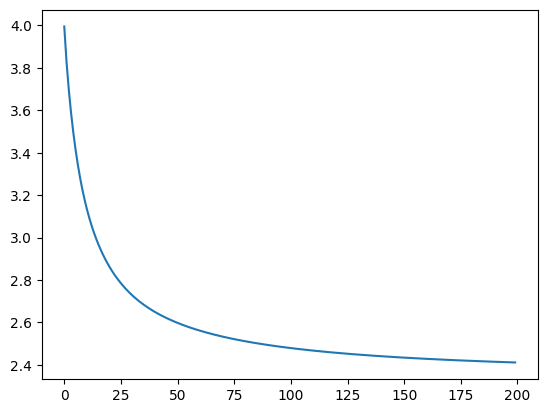

In [33]:
lossi= []
progress_bar = tqdm(range(200))
xenc=F.one_hot(xs,num_classes=27).float()
for k in progress_bar:
    # forward pass
    num=xs.shape[0]
    logits= xenc.view(-1,54)@W
    counts = logits.exp()
     
    probs = counts/counts.sum(1,keepdims=True)
    # loss calculation
    loss = -probs[torch.arange(num),ys].log().mean() +0.01*(W**2).mean() #regularization ie smoothing the weights
    
    # loss=F.cross_entropy(probs,ys)
    W.grad=None 
    loss.backward()
    progress_bar.set_postfix(loss = loss.data)
    lossi.append(loss.data)
    # update
    W.data += -10 * W.grad
     
plt.plot(lossi)

In [28]:
xenc.shape

torch.Size([228146, 729])

In [26]:
for i in range(10):

  ix = torch.tensor([0,0])
  out = []
  
  while True:
    # p=P[ix]   
    xenc = F.one_hot(ix,num_classes=27).view(-1,54).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts/counts.sum(1,keepdims=True)
    isample = torch.multinomial(p,num_samples=1,replacement=True, ).item()
    
    out.append(itos[isample])
    ix[0] = ix[1]
    ix[1] = isample
    if isample == 0:
      break
    
     
  print(''.join(out))

mul.
trreelahrasanardennitzfd.
tven.
ai.
naakirandigszmbgcald.
kadyt.
sne.
kari.
hy.
zemdeahockana.


100%|██████████| 200/200 [00:30<00:00,  6.57it/s, loss=tensor(2.3377)]


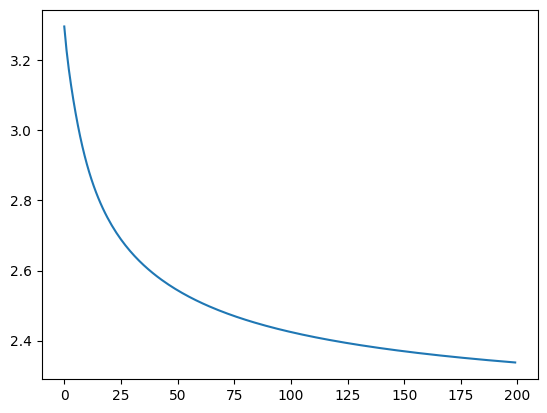

In [27]:
W = torch.randn((729, 27))*0.01;W.requires_grad = True
lossi= []

xenc=F.one_hot(xs[:,0] * 27 + xs[:,1],num_classes=729).float()
progress_bar = tqdm(range(200))
for k in progress_bar:
    # forward pass
    num=xs.shape[0]
    logits= xenc.view(-1,729)@W
    counts = logits.exp()
     
    probs = counts/counts.sum(1,keepdims=True)
    # loss calculation
    loss = -probs[torch.arange(num),ys].log().mean() +0.01*(W**2).mean() #regularization ie smoothing the weights
    # loss=F.cross_entropy(probs,ys) 
    W.grad=None 
    loss.backward()
    lossi.append(loss.data)
    # update
    progress_bar.set_postfix(loss = loss.data)
    W.data += -50 * W.grad
    
plt.plot(lossi)

In [208]:
#Yay almost the same loss as the model with direct Prob matrix

# Now we will sample the MLP model
for i in range(20):

  ix1 = 0
  ix2 = 0
  out = []
  
  while True:
    # p=P[ix]   
    xenc = F.one_hot(torch.tensor([ix1 * 27 + ix2]),num_classes=729).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts/counts.sum(1,keepdims=True)
    isample = torch.multinomial(p,num_samples=1,replacement=True, ).item()
    
    out.append(itos[isample])
    ix1 = ix2
    ix2 = isample
    if isample == 0:
      break
  print(''.join(out))

nokszxlharleen.
adi.
betane.
zrhen.
kie.
emxfccorl.
sapbwjvdrci.
fiene.
nmwvqfxwh.
zskcsqamaartertkoblqczjjbfigh.
boswsvon.
anaochadenton.
da.
jaqkosf.
sa.
ay.
da.
saoorqehlorrkxkoehdvfyizki.
jduqesty.
emeri.
